# Experiment: Varying N in top-N DDA fragmentation

We demonstrate that the simulator can be used for scan-level closed-loop DDA experiments. 
- Take an existing data. Find out which MS1 peaks are linked to which MS2 peaks.
- Run all MS1 peaks through the simulator’s Top-N protocol. 
- For the top-100 most intense MS1 peaks, how many got fragmented in the simulator as we change N?
- If N is greater than the real data, do we see the same MS1 peaks from (1) being fragmented again, plus additional fragment peaks?
- Verification on actual machine.
- Talk to stefan about machine time.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import os
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
from random import random, shuffle
from joblib import Parallel, delayed
import multiprocessing

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

In [6]:
set_log_level_debug()

### Load densities trained on beer1pos data (see [loader_kde](loader_kde.ipynb)).

In [7]:
base_dir = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\'

In [8]:
ps = load_obj(base_dir + 'Trained Models\\peak_sampler_beer1pos_fragmentation.p')

### Load chromatogram data exported from the real data (BEER1POS)

Correct the positively charged ions by substracting the mass of a proton

In [9]:
def f(peak_mz, chrom_mzs):
    peak_mz = peak_mz - PROTON_MASS
    chrom_mzs = chrom_mzs - PROTON_MASS
    return peak_mz, chrom_mzs

In [10]:
xcms_output = base_dir + 'Trained Models\\chromatogram_beer1pos.csv.gz'
cc = ChromatogramCreator(xcms_output, correction_func=f)

INFO:ChromatogramCreator:Loading 0 chromatograms
INFO:ChromatogramCreator:Loading 5000 chromatograms
INFO:ChromatogramCreator:Loading 10000 chromatograms


#### Turn the loaded data into `UnknownChemical` objects.

In [11]:
min_ms1_intensity = 0
min_rt = 3*60
max_rt = 21*60
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

DEBUG:ChemicalCreator:10321 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 2500
DEBUG:ChemicalCreator:i = 5000
DEBUG:ChemicalCreator:i = 7500


In [12]:
len(dataset)

9828

### Add noise

#### Create region of interest objects

In [13]:
mzml_path = base_dir + 'Data\\multibeers_urine_data\\beers\\fullscan\\'
xcms_roi_file = mzml_path + 'rois.csv'
extracted_roi_file = base_dir + 'Trained Models\\beer1pos_rois.p'

In [14]:
filename = 'Beer_multibeers_1_fullscan1.mzML'
ds = DataSource()
ds.load_data(mzml_path)
try:
    ds.load_roi(extracted_roi_file)
except FileNotFoundError:
    print('Extracting ROIs')
    ds.extract_roi(xcms_roi_file, min_rt=min_rt, max_rt=max_rt, filename=filename)
    ds.populate_roi(filename=filename)
    ds.save_roi(extracted_roi_file)

C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_10_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_10_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_11_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_11_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_12_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_12_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_13_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_13_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_14_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_14_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_15_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_15_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_16_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_16_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_17_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_17_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_18_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_18_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_19_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_19_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_1_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_1_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_2_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_2_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_3_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_3_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_4_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_4_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_5_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_5_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_6_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_6_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_7_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_7_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_8_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_8_fullscan1.mzML


C:\Users\joewa\University of Glasgow\Vinny Davies - CLDS Metabolomics Project\Data\multibeers_urine_data\beers\fullscan\Beer_multibeers_9_fullscan1.mzML


INFO:DataSource:Loading Beer_multibeers_9_fullscan1.mzML


#### Add a whole bunch of `UnknownChemicals` with chromatograms coming from non-peak ROIs from Beer1Pos

In [15]:
min_ms1_intensity = 2.5E5
min_ms1_intensity = 0

In [16]:
rtcc = RoiToChemicalCreator(ps, ds, filename,  min_ms1_intensity=min_ms1_intensity)

DEBUG:RoiToChemicalCreator:     0/ 17569
INFO:RoiToChemicalCreator:Found 17549 ROIs above thresholds


In [17]:
len(rtcc.chemicals)

17549

In [18]:
def plot_chems(chem_list, N=10):
    for c in chem_list[0:N]:
        chrom = c.chromatogram
        plt.plot(chrom.raw_rts, chrom.raw_intensities)
        plt.show()

In [19]:
sorted_chems = sorted(rtcc.chemicals, key = lambda chem: chem.chromatogram.roi.num_scans())

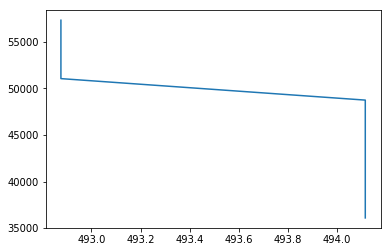

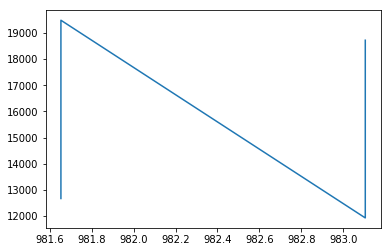

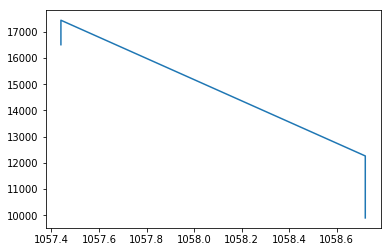

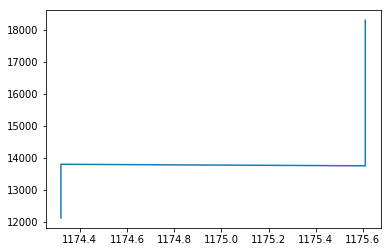

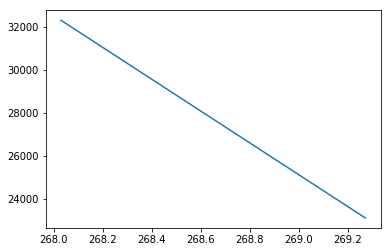

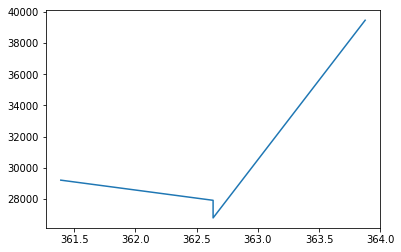

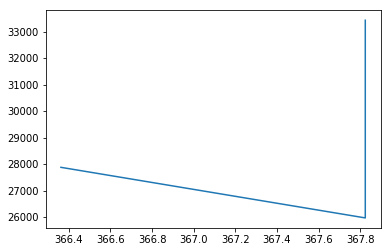

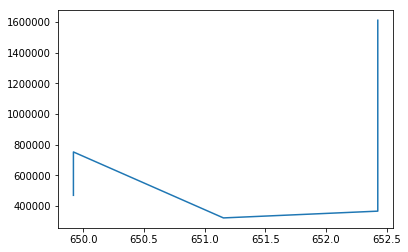

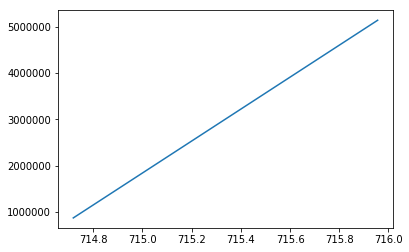

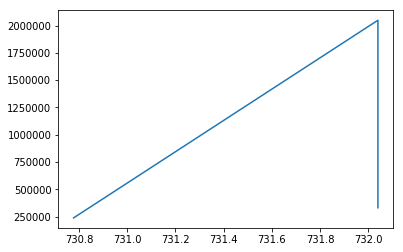

In [20]:
plot_chems(sorted_chems[0:10])

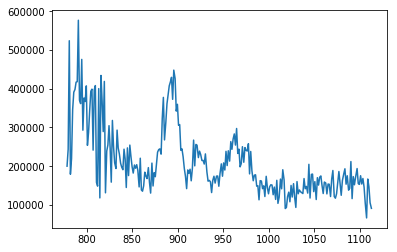

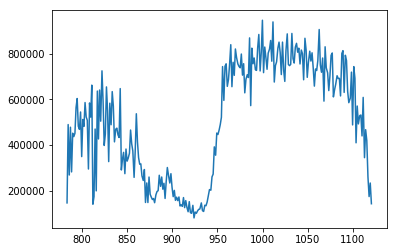

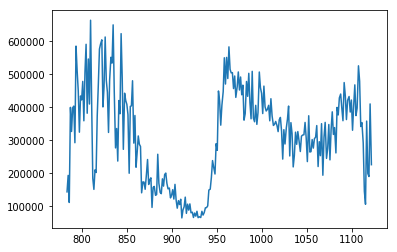

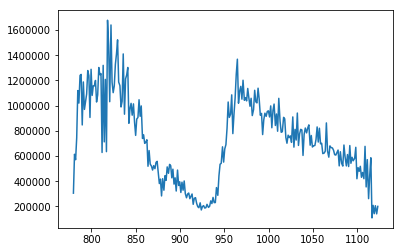

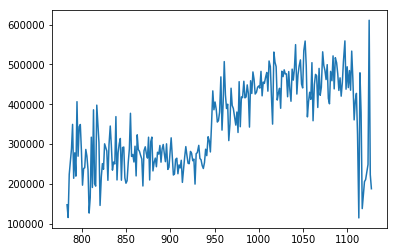

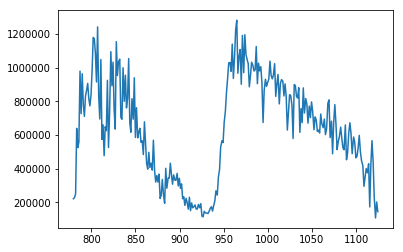

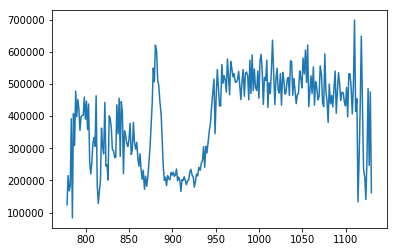

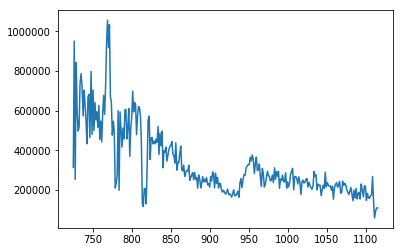

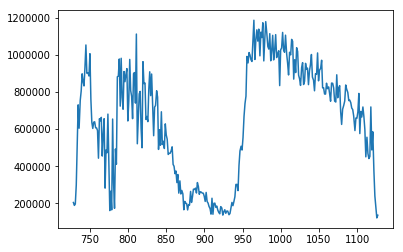

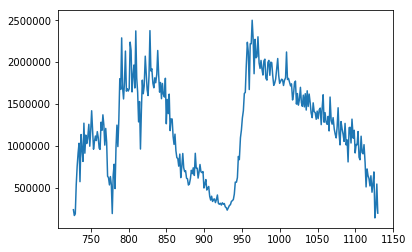

In [21]:
plot_chems(sorted_chems[-10:])

#### Add non-peaks regions of interest to the data

In [22]:
for chem in dataset:
    chem.type = 'data'
for noise in sorted_chems:
    noise.type = 'noise'

In [23]:
noisy_dataset = dataset + sorted_chems

In [24]:
# shuffle(noisy_dataset)

In [25]:
len(dataset)

9828

In [26]:
len(noisy_dataset)

27377

In [27]:
save_obj(dataset, '../models/dda_results/dataset.p')

In [28]:
save_obj(noisy_dataset, '../models/dda_results/noisy_dataset.p')